# TOC
- [Process annotation map](#process_annotation)
- [Remove background color](#remove_background)
- [Convert to COCO format](#format_coco)
- [Visualize](#visualize)
    - [Customized visualization](#visualize_customized)
    - [Default visualization](#visualize_default)
- [Data augmentation](#data_aug)
    - [Vesicles - copy paste](#vesicles_aug)
    - [Nanorods - copy paste](#nanorods_aug)
    - [Defaults - detectron2](#detectron2)
- [Debug](#debug)
    - [Vesicles - create simple test image](#vesices_simple)
    - [Vesicles - COCO functions](#vesices_coco)
    - [Vesicles - Paste objects onto images, without rotation, with background, regardless of source image](#vesices_paste_bad)
    - [Nanorods - create simple test image](#nanorods_simple)


### refs
- polygon from pixel mask: https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#create-custom-coco-dataset
- pixel mask & full example include register (BAD annotation): https://www.kaggle.com/jeanpat/minimalist-mask-to-coco-format-dataset-conversion 
- official examples (not used): https://github.com/matterport/Mask_RCNN/blob/v2.1/samples/balloon/balloon.py, https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/coco.py



In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import cv2
import regex as re
from PIL import Image       
import glob
import json
import IPython
import pickle
from copy import deepcopy
from collections import Counter
import imutils
import math 

import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from pathlib import Path   
from detectron2.data.datasets import register_coco_instances
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine.defaults import DefaultPredictor

import data_utils
from helpers_coco import color_ids, category_ids, id_colors, class_info
from helpers_coco import images_annotations_info, create_sub_masks, create_sub_mask_annotation, create_category_annotation, create_image_annotation, create_annotation_format, get_coco_json_format
from helpers_coco import CocoDataset
from helpers_coco import process_img_pixel_annotation
from helpers_coco import list_imgs_in_dir, standardize_color, clean_annotation_mask, remove_noise
from helpers_coco import display_ddicts


In [17]:

# fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train_coco/train.json'
fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val_coco_all/val.json'


with open(fname, 'r') as f:
    tmp = json.load(f)
cnt_large=0
cnt_small=0
cnt_hole=0
for anno in tmp['annotations']:
    if anno['category_id'] == 1:
        cnt_large += 1
    if anno['category_id'] == 2:
        cnt_small += 1
    if anno['category_id'] == 3:
        cnt_hole += 1
print(cnt_large, cnt_small, cnt_hole)


79 155 29


In [14]:
tmp

{'info': {},
 'licenses': [],
 'images': [{'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1724_0004_ceta.png',
   'height': 2048,
   'width': 2048,
   'id': 0},
  {'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1729_0000_ceta.png',
   'height': 2048,
   'width': 2048,
   'id': 1},
  {'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1714_0003_ceta.png',
   'height': 2048,
   'width': 2048,
   'id': 2},
  {'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1729_0003_ceta.png',
   'height': 2048,
   'width': 2048,
   'id': 3},
  {'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1733_0002_ceta.png',
   'height': 2048,
   'width': 2048,
   'id': 4},
  {'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicl

# Process annotation map<a id='process_annotation'></a>

In [3]:
# input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
# output_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_mask/'
input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_raw/'
output_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_clean_mask/'

process_img_pixel_annotation(input_dir, output_dir)



20190405_2.0_kx_micro_1724_0004_ceta_mask.png
20190405_2.0_kx_micro_1731_0000_ceta_mask.png
20190405_2.0_kx_micro_1708_0004_ceta_mask.png
20190405_2.0_kx_micro_1645_0002_ceta_mask.png
20190405_2.0_kx_micro_1724_0001_ceta_mask.png
20190405_2.0_kx_micro_1729_0000_ceta_mask.png
OVERLAPPING mask in:  20190405_2.0_kx_micro_1731_0002_ceta-2.png
20190405_2.0_kx_micro_1731_0002_ceta_mask.png
OVERLAPPING mask in:  20190405_2.0_kx_micro_1727_0001_ceta-3.png
20190405_2.0_kx_micro_1727_0001_ceta_mask.png
20190405_2.0_kx_micro_1733_0002_ceta_mask.png
20190405_2.0_kx_micro_1714_0003_ceta_mask.png
20190405_2.0_kx_micro_1729_0003_ceta_mask.png
20190405_2.0_kx_micro_1728_0003_ceta_mask.png
20190405_2.0_kx_micro_1731_0003_ceta_mask.png
20190405_2.0_kx_micro_1730_0004_ceta_mask.png
20190405_2.0_kx_micro_1646_0000_ceta_mask.png
20190405_2.0_kx_micro_1645_0001_ceta_mask.png


### Debug

In [5]:
### get individual image colors
from collections import Counter
colors = Counter()
img = cv2.imread(output_dir + '20190405_2.0_kx_micro_1727_0001_ceta_mask.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in np.arange(img.shape[0]):
    for j in np.arange(img.shape[1]):
        colors[tuple(img[i, j,:])] += 1
colors


Counter({(0, 0, 0): 3350576,
         (0, 255, 0): 323693,
         (0, 0, 255): 1735,
         (255, 255, 0): 51345,
         (255, 0, 0): 465667,
         (255, 255, 255): 1288})

In [ ]:
### for all images in dir, check which ones contain (0, 255, 255)
print('images with bad color (0, 255, 255)')
for f in os.listdir(output_dir):
    img = cv2.imread(output_dir + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_active = (img[:, :, 0] == 255).astype(int) + (img[:, :, 1] == 255).astype(int)*10 + (img[:, :, 2] == 255).astype(int)*100
    count = np.sum((test_active == 110).astype(int))
    if count > 0:
        print(f, count)




In [8]:
### check color of overlapping images
errors_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_clean_mask_errors/'

cnt = 0
colors = Counter()
for f in os.listdir(errors_dir):
    img = cv2.imread(errors_dir + f)
    cnt += np.sum(img>0)

    for i in np.arange(img.shape[0]):
        for j in np.arange(img.shape[1]):
            colors[tuple(img[i, j, :])] += 1
print(colors, cnt)



Counter({(0, 0, 0): 12582722, (255, 0, 0): 170, (0, 255, 0): 20}) 190


In [1]:
### check where are the bad colors located on an image
img = cv2.imread(output_dir + '20190405_2.0_kx_micro_1731_0000_ceta_mask.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
test_active = (img[:, :, 0] == 255).astype(int) + (img[:, :, 1] == 255).astype(int)*10 + (img[:, :, 2] == 255).astype(int)*100
bad_color = test_active == 110

plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(bad_color)

In [36]:
def process_img_pixel_annotation_one_color(input_dir, output_dir, color):
    """
    read annotation map(s and combine them), clean them and write the standard mask to output_dir png file
        assumes image file name 'img_name', its raw mask file name 'img_name ([\d])' (and no more than 9 masks)
    ------------
    inputs
        fname, str, original image file name
        out_dir, str, output directory
        color = [3, ], RGB values of color channel
    """
    ### create dirs
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    ### combine masks
    color_val = np.sum((np.array(color) > 0).astype(int) * np.array([1, 10, 100]))
    names = list_imgs_in_dir(input_dir)
    print (names)
    for img_name in names.keys():
        mask = np.zeros(cv2.imread(input_dir + img_name).shape, dtype=np.uint8)
        for mask_name in names[img_name]:
            mask_tmp = cv2.imread(input_dir + mask_name)
            mask_tmp = cv2.cvtColor(mask_tmp, cv2.COLOR_BGR2RGB)  # cv2 defaul is BRG color order
            mask_tmp = clean_annotation_mask(mask_tmp)

            was_exist = (mask_tmp[:, :, 0] == 255).astype(int) + (mask_tmp[:, :, 1] == 255).astype(int)*10 + (mask_tmp[:, :, 2] == 255).astype(int)*100
            was_exist = (was_exist == color_val)
            new_exist = (mask[:, :, 0] == 255).astype(int) + (mask[:, :, 1] == 255).astype(int)*10 + (mask[:, :, 2] == 255).astype(int)*100
            new_exist = (new_exist == color_val)
            either_exist = was_exist + new_exist

            mask[either_exist] = color

        ### write combined mask file
        idx = img_name.rfind('.')
        mask_name = img_name[:idx] + '_mask' + img_name[idx:]
        print(mask_name)
        cv2.imwrite(output_dir + mask_name, cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))

        
        
        

In [37]:
input_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data_test/vesicles_easy_raw/'
output_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data_test/vesicles_easy_mask/'
color = [0, 255, 0]
process_img_pixel_annotation_one_color(input_dir, output_dir, color)

defaultdict(<class 'list'>, {'crop2.png': ['crop2-2.png']})
crop2_mask.png


# Remove background color<a id='remove_background'></a>

In [11]:
import json 

color = 3
tag = ''
fnames = [f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_coco_{color}{tag}/train.json',
        f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val_coco_{color}{tag}/val.json']

for fname in fnames:
    with open(fname, 'r') as f:
        tmp = json.load(f)
    f.close()
#     tmp['categories'] = tmp['categories'][1:]
#     with open(fname, 'w') as f:
#         json.dump(tmp, f)
#     f.close()
        

In [2]:
color = 1
tag = ''
with open(f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val_coco_{color}{tag}/val.json', 'r') as f:
    data = json.load(f)
f.close()
data

In [ ]:
import shutil
keywords = ['train', 'val']
tag = '_nobackground'
color = 'all'
for keyword in keywords:
    os.makedirs(f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_{keyword}_coco_{color}{tag}/', exist_ok=True)
    shutil.copyfile(f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_{keyword}_coco_{color}/{keyword}.json', 
                   f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_{keyword}_coco_{color}{tag}/{keyword}.json')
    
    
    

In [ ]:
# my_val_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data_test/vesicles_easy_coco/train.json'
my_val_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_coco_all_nobackground/train.json'
holm_val_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/AMPIS/examples/powder/data/via_2.0.8/via_powder_particle_masks_validation.json'

with open(my_val_file, 'r') as f:
    my_val = json.load(f)


with open(holm_val_file, 'r') as f:
    holm_val = json.load(f)
    
    

# Convert to COCO format<a id='format_coco'></a>

In [3]:
# Label ids of the dataset
category_ids = {
    "background": 0,
    "large_vesicle": 1,
    "small_vesicle": 2,
    "hole_vesicle": 3,
    "hole": 4,
    "vague_large_vesicle": 5
}

# Define which colors match which categories in the images
color_ids = {
    "(0, 0, 0)": 0,# background
    "(255, 0, 0)": 1, # large_vesicle
    "(0, 255, 0)": 2, # small_vesicle
    "(255, 255, 0)": 3, # hole_vesicle
    "(0, 0, 255)": 4, # hole
    "(255, 255, 255)": 5, # vague_large_vesicle
}


keyword = ''
tag = '_aug3'


# ['train', 'val']
for keyword in ['val']:

    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()

    # Create category section
    coco_format["categories"] = create_category_annotation(category_ids)

    # Create images and annotations sections
    input_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_{keyword}{tag}/'
    mask_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_{keyword}{tag}_mask/'
    coco_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_{keyword}{tag}_coco/'
    if not os.path.isdir(coco_dir):
        os.makedirs(coco_dir)
        
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_dir, input_dir,
                                                                                                category_ids, color_ids)

    with open(coco_dir + "/{}.json".format(keyword),"w") as outfile:
        json.dump(coco_format, outfile)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_dir))


In [38]:
mask_val_dir = f'/usr/workspace/zhong2/Research/FeedOpt/QuesTek/Data/vesicles_val_mask_{color_target}/'
os.makedir(mask_val_dir)
for img_name in os.listdir('/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_val'):
    idx = img_name.rfind('.')
    mask_name = img_name[:idx] + '_mask' + img_name[idx:]
    shutil.move(mask_dir + maks_name, mask_val_dir + mask_name)

# Visualize<a id='visualize'></a>

### Customized visualization<a id='visualize_customized'></a>

In [9]:
# annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/image-to-coco-json-converter/output/val.json"
# image_dir = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/image-to-coco-json-converter/dataset/val"
# annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_coco/train.json"
# image_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_train_coco/train.json"
image_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_train/'

coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
# coco_dataset.display_licenses()
# coco_dataset.display_categories()

html = coco_dataset.display_image(10, use_url=False)
IPython.display.HTML(html)

Image:
  file_name: /Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_train/20190405_2.0_kx_micro_1728_0003_ceta.png
  height: 2048
  width: 2048
  id: 10
  segmentations (274):
    1895:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1896:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1897:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1898:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1899:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1900:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1901:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1902:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1903:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}
    1904:red:{'supercategory': 'large_vesicle', 'id': 1, 'name': 'large_vesicle'}

### Default visualization<a id='visualize_default'></a>

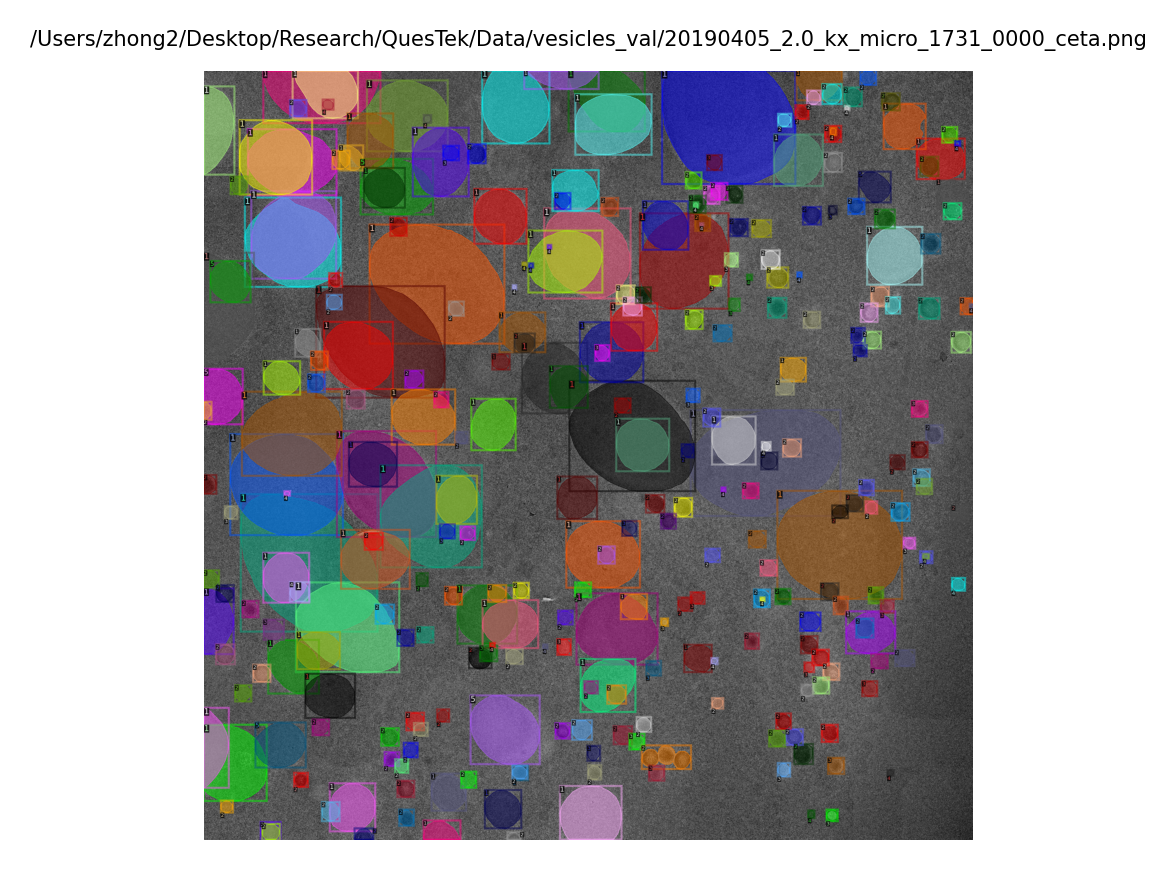

In [5]:
from detectron2.utils.visualizer import Visualizer

img_file = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_val/20190405_2.0_kx_micro_1731_0000_ceta.png'
f = open('/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_val_coco/val.json','r')
coco_format = json.load(f)
f.close()
visualizer = Visualizer(cv2.imread(img_file), scale=1)
vis = visualizer.draw_dataset_dict(coco_format)
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.imshow(vis.get_image())
ax.axis('off')
ax.set_title('{}'.format(img_file), fontsize=5)
fig.tight_layout()
plt.show()
# plt.close(fig)

# Data augmentation<a id='data_aug'></a>

## Vesicles - copy paste<a id='vesicles_aug'></a>

In [124]:
fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_coco_all/train.json'
with open(fname, 'r') as f:
    coco = json.load(f)

# ### collect raw images
imgs = {}
for img_info in coco['images']:
    img = cv2.imread(img_info['file_name'], 0)
    imgs[img_info['id']] = img
masks = {}
for img_info in coco['images']:
    tmp = img_info['file_name'].split('/')
    mask_name = '/'.join(tmp[:-1]) + '_mask_all/' + '.'.join(tmp[-1].split('.')[:-1]) + '_mask.' + tmp[-1].split('.')[-1]
    mask = cv2.cvtColor(cv2.imread(mask_name), cv2.COLOR_BGR2RGB)
    masks[img_info['id']] = mask


### Collect objects from all images
- Note that non-extended bounding box can also contin other objects because objects have round shape

In [75]:
def get_img_patch(img, bbox, extend_size=5):
    r_start = max(bbox[1] - extend_size, 0)
    r_end = min(bbox[1] + bbox[3] + extend_size, img.shape[0])
    c_start = max(bbox[0] - extend_size, 0)
    c_end = min(bbox[0] + bbox[2] + extend_size, img.shape[1])
    box_size = [c_end - c_start, r_end - r_start] 
    return img[r_start: r_end, c_start: c_end], box_size

def clean_mask_patch(mask_patch):
    mask_patch_2 = deepcopy(mask_patch)   ### deepcopy is necessary
    
    ### Keep largest component only
    num_labels, labels = cv2.connectedComponents(cv2.cvtColor(mask_patch_2, cv2.COLOR_RGB2GRAY))
    labels_cnt = Counter(list(labels.flatten())).most_common()
    for idx, cnt in labels_cnt:
        if np.sum(mask_patch_2[labels == idx]) > 0:
            idx_main_obj = idx
            break
    mask_tmp = labels == idx_main_obj
    mask_patch_2[~mask_tmp, :] = 0
    
    ### Remove a secondary color if it touch box boundary
    boundary_colors = np.concatenate((mask_patch[0, :, :], mask_patch[-1, :, :], mask_patch[:, 0, :], mask_patch[:, -1, :]), axis=0)
    boundary_colors = np.unique(boundary_colors, axis=0)
    boundary_colors = set(tuple(color) for color in boundary_colors)
    if len(boundary_colors) > 2:
        remove_colors = boundary_colors - {(0, 0, 0), eval(id_colors[annotation['category_id']])}
        remove_colors = list(remove_colors)

        for remove_color in remove_colors:
            mask_tmp = (mask_patch_2[:, :, 0] == remove_color[0]) & (mask_patch_2[:, :, 1] == remove_color[1]) & (mask_patch_2[:, :, 2] == remove_color[2])     
            mask_patch_2[mask_tmp, :] = 0
            
    return mask_patch_2


In [81]:
# save_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_img_objects.pkl'
# with open(fname, 'rb') as f:
#     img_objects = pickle.load(f)

# img_objects

### prepare help info: images and categories
img_objects = {}
img_objects['images'] = coco['images']
categories = coco['categories']
img_objects['categories'] = categories
for category in categories:
    category_name = category['supercategory']
    img_objects[category_name] = {}
    for i in np.arange(len(img_objects['images'])):
        img_objects[category_name][i] = []
    

### go over annotations and record corresponding image patch
for (i, annotation) in enumerate(coco['annotations']):
    category_id = annotation['category_id']
    category_name = categories[category_id]['supercategory']
    
    img = imgs[annotation['image_id']]
    mask = masks[annotation['image_id']]
    bbox = annotation['bbox']
    
    bbox = np.ceil(bbox).astype(int)
    mask_patch, box_size = get_img_patch(mask, bbox, extend_size=0)
    
    mask_patch_clean = clean_mask_patch(mask_patch)
    
    img_patch, box_size = get_img_patch(img, bbox, extend_size=0)
    img_object = {
        'img_id': annotation['image_id'],
        'size': box_size,
        'img_patch': img_patch,
        'mask_patch': mask_patch_clean,
    }
    img_objects[category_name][annotation['image_id']].append(img_object)

    
save_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/'
os.makedirs(save_dir, exist_ok=True)
fname = save_dir + 'vesicles_img_objects.pkl'
with open(fname, 'wb') as f:
    pickle.dump(img_objects, f)

    
# print(img_objects.keys())
# print('#small_vesicle = ', len(img_objects['small_vesicle']))  # correct = 1735
# print('#hole_vesicle = ', len(img_objects['hole_vesicle']))  # correct = 454
    

#### Check one individual annoation

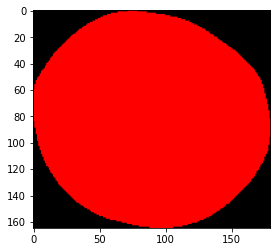

In [299]:
### edge cases, more than one object in a window [221];  with hole [33, 55] 
annotation = coco['annotations'][221]

img = imgs[annotation['image_id']]
mask = masks[annotation['image_id']]
bbox = annotation['bbox']
bbox = np.ceil(bbox).astype(int)
(mask_patch, box_size) = get_img_patch(mask, bbox, extend_size=0)

mask_patch_clean = clean_mask_patch(mask_patch)

plt.imshow(mask_patch_clean)


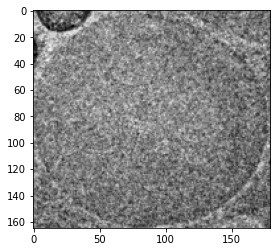

In [295]:
img_patch, box_size = get_img_patch(img, bbox, extend_size=0)
plt.imshow(img_patch, cmap='gray')

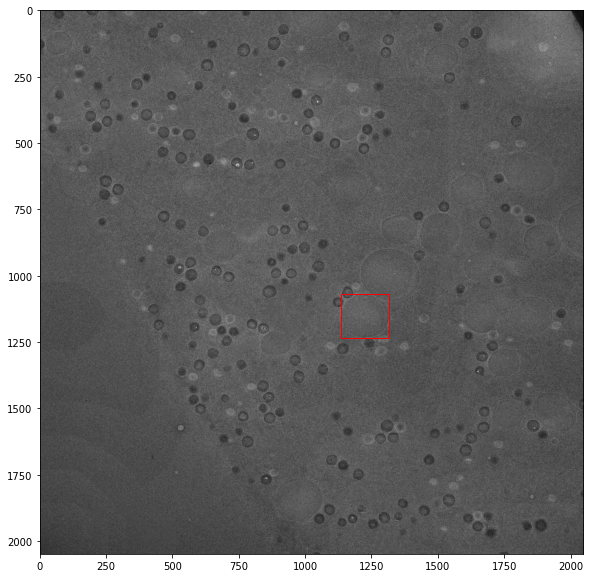

In [291]:
import matplotlib.patches as patches
img = cv2.imread(coco['images'][0]['file_name'], 0)

# plt.figure()
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(img, cmap='gray')
# Create a Rectangle patch
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Paste objects onto images, with rotation, without background, within source image 

In [82]:
def pad_img_for_rotate(img):
    largest_size = int(np.max(img.shape) * np.sqrt(2))
    pad_size_0 = int((largest_size - img.shape[0]) / 2) # #pads needed for axis 0
    pad_size_1 = int((largest_size - img.shape[1]) / 2) # #pads needed for axis 1
    
    if len(img.shape) == 2:
        img_paded = np.pad(img, ((pad_size_0, pad_size_0), (pad_size_1, pad_size_1)), 'constant', constant_values=0)
    if len(img.shape) == 3:
        img_paded = np.pad(img, ((pad_size_0, pad_size_0), (pad_size_1, pad_size_1), (0, 0)), 'constant', constant_values=0)
    
    return img_paded


In [139]:
obj_name = 'small_vesicle'
obj_per_img = 100
total_trails = 10000
i = 10
apply_rotation_and_flip = True

img_dir_out = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_aug2_raw/'
mask_dir_out = img_dir_out
os.makedirs(img_dir_out, exist_ok=True)
os.makedirs(mask_dir_out, exist_ok=True)

# img = deepcopy(imgs[i])
# mask = deepcopy(masks[i])
for i in range(len(imgs)):
# for i in range(1):
    img = deepcopy(imgs[i])
    mask = deepcopy(masks[i])

    ### gather objects within image
    objs_img = img_objects[obj_name][i]
    obj_idxs = np.random.randint(0, high=len(objs_img), size=obj_per_img, dtype=int)

    ### paste objects into image
    n_trial = 0 
    for obj_idx in obj_idxs:
        obj = objs_img[obj_idx]
        if apply_rotation_and_flip:
            obj_box_size = int(np.max(obj['size']) * np.sqrt(2)) * np.array([1, 1])
        else:
            obj_box_size = obj['size']

        continue_trying = True
        while continue_trying:
            r = np.random.randint(0, high=img.shape[0] - obj_box_size[1], size=1, dtype=int)[0]
            c = np.random.randint(0, high=img.shape[1] - obj_box_size[0], size=1, dtype=int)[0]

            ### check if a random position is good (only contain background)
            area_candidate = mask[r: r+obj_box_size[1], c: c+obj_box_size[0]]
            pos_good = (len(np.unique(area_candidate)) == 1) and (np.unique(area_candidate)[0] == 0)
            if pos_good:
                img_patch = obj['img_patch']
                mask_patch = obj['mask_patch']

                if apply_rotation_and_flip:
                    img_patch = pad_img_for_rotate(img_patch)
                    mask_patch = pad_img_for_rotate(mask_patch)

                    ang = np.random.choice([90, 180, 270], 1)[0]
                    img_patch = imutils.rotate(img_patch, angle=ang)
                    mask_patch = imutils.rotate(mask_patch, angle=ang)

                    flip_code = np.random.choice([-1, 0, 1], 1)[0]  # https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441
                    img_patch = cv2.flip(img_patch, flip_code)
                    mask_patch = cv2.flip(mask_patch, flip_code)
                    obj_box_size = [img_patch.shape[1], img_patch.shape[0]]

                ### paste
                mask_bw = cv2.cvtColor(mask_patch, cv2.COLOR_RGB2GRAY)
                img[r: r+obj_box_size[1], c: c+obj_box_size[0]][mask_bw > 0] = img_patch[mask_bw > 0]
                mask[r: r+obj_box_size[1], c: c+obj_box_size[0]] = mask_patch
                continue_trying = False

            n_trial += 1
            if n_trial >= total_trails:
                continue_trying = False
    
    fname = coco['images'][i]['file_name'].split('/')[-1]
    cv2.imwrite(img_dir_out + fname, img)
    mask_name = fname[:-4] + '-2' + fname[-4:]
    cv2.imwrite(mask_dir_out + mask_name, cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))
    
    print(n_trial)


262
342
179
253
310
282
285
266
321
191
299
330
262
350


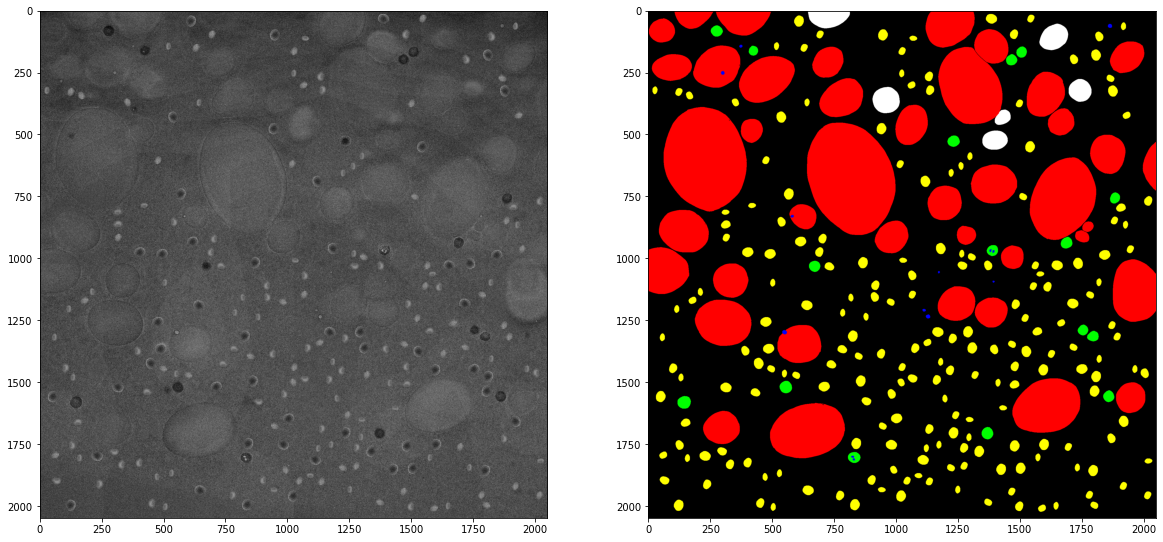

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(mask)

In [138]:
img_dir_out + fname

'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_aug2_raw/20190405_2.0_kx_micro_1708_0004_ceta.png'

## Nanorods - copy paste<a id='nanorods_aug'></a>

## Defaults - detectron2<a id='detectron2'></a>

# Debug<a id='debug'></a>
- background is also being annotated: visualize sub_masks['(0, 0, 0)']

### Vesicles, create simple test image<a id='vesices_simple'></a>

True

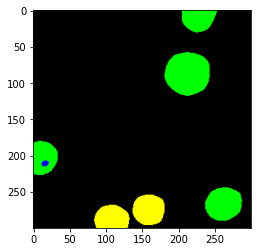

In [27]:
input_img_name = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train/20190405_2.0_kx_micro_1645_0001_ceta.png'
input_mask_name = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_mask/20190405_2.0_kx_micro_1645_0001_ceta_mask.png'
w_img_name = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data_test/vesicles_easy_raw/crop2-1.png'
w_mask_name = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data_test/vesicles_easy_raw/crop2-2.png'
img = cv2.imread(input_img_name, 0)
mask = cv2.imread(input_mask_name)
img_crop = img[:300, -300:]
mask_crop = mask[:300, -300:]
plt.imshow(cv2.cvtColor(mask_crop, cv2.COLOR_BGR2RGB))


cv2.imwrite(w_img_name, img_crop)
cv2.imwrite(w_mask_name, mask_crop)


In [396]:
input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'
mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask/'
coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco/'

if not os.path.isdir(coco_dir):
    os.makedirs(coco_dir)

    
#     for keyword in ['train', 'val']:
keyword = 'train'

# Get the standard COCO JSON format
coco_format = get_coco_json_format()

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)

# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_dir, input_dir)

with open(coco_dir + "/{}.json".format(keyword),"w") as outfile:
    json.dump(coco_format, outfile)

print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_dir))

Created 2 annotations for images in folder: /Users/zhong2/Desktop/Research/QuesTek/vesicles_easy_mask/


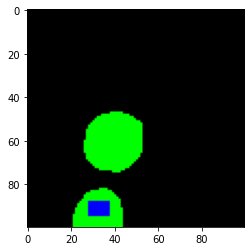

In [66]:
mask_name = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data_test/vesicles_easy_mask/crop1_mask.png'
mask = cv2.imread(mask_name)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask[88:95, 28:38, 1] = 0
mask[88:95, 28:38, 2] = 255

plt.imshow(mask)
# w_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask_hole/crop1_mask_hole.png'
# cv2.imwrite(w_name, mask)



### Vesicles, COCO functions <a id='vesices_coco'></a>

In [ ]:
# Label ids of the dataset
category_ids = {
    "background": 0,
    "large_vesicle": 1,
    "small_vesicle": 2,
    "hole_vesicle": 3,
    "hole": 4,
    "vague_large_vesicle": 5
}

# Define which colors match which categories in the images
color_ids = {
    "(0, 0, 0)": 0,# background
    "(255, 0, 0)": 1, # large_vesicle
    "(0, 255, 0)": 2, # small_vesicle
    "(255, 255, 0)": 3, # hole_vesicle
    "(0, 0, 255)": 4, # hole
    "(255, 255, 255)": 5, # vague_large_vesicle
}


# input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
# mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_mask/'
# coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_coco/'
input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'
mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask_hole/'
coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco_hole/'

if not os.path.isdir(coco_dir):
    os.makedirs(coco_dir)

    
#     for keyword in ['train', 'val']:
keyword = 'train'

# Get the standard COCO JSON format
coco_format = get_coco_json_format()

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)

# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_dir, input_dir,
                                                                                           category_ids, color_ids)

with open(coco_dir + "/{}.json".format(keyword),"w") as outfile:
    json.dump(coco_format, outfile)

print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_dir))



### visualization
annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco_hole/train.json"
image_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'

coco_dataset = CocoDataset(annotation_path, image_dir)
html = coco_dataset.display_image(0, use_url=False)
IPython.display.HTML(html)

In [106]:
### function create_sub_mask_annotation
sub_mask = sub_masks['(0, 255, 0)']

contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")
sub_mask_array = np.array(sub_mask)

polygons = []
segmentations = []
for contour in contours:
    # Flip from (row, col) representation to (x, y)
    # and subtract the padding pixel
    for i in range(len(contour)):
        row, col = contour[i]
        contour[i] = (col - 1, row - 1)

    # Check if the contour is a hole
    # !!!!!!!!!!!!!!! THIS LOGIC IS PROBLEMATIC !!!!!!!!!!!!!!!
    r_mask = np.zeros_like(np.array(sub_mask), dtype='bool')
    r_mask[np.round(contour[:, 1]).astype('int'), np.round(contour[:, 0]).astype('int')] = 1
    r_mask = ndimage.binary_fill_holes(r_mask)
    vals_in_contour = sub_mask_array[r_mask]
    if vals_in_contour.mean() < 0.5:
        print(vals.mean())
        continue
        
    # Make a polygon and simplify it
    poly = Polygon(contour)
    poly = poly.simplify(1.0, preserve_topology=False)

    if(poly.is_empty):
        # Go to next iteration, dont save empty values in list
        continue

    polygons.append(poly)

    segmentation = np.array(poly.exterior.coords).ravel().tolist()
    segmentations.append(segmentation)

len(segmentations)

0.22077922077922077


2

### Vesicles - Paste objects onto images, without rotation, with background, regardless of source image <a id='vesices_paste_bad'></a>

In [11]:
# fname = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_img_objects.pkl'
# with open(fname, 'rb') as f:
#     img_objects = pickle.load(f)
    
obj_name = 'hole_vesicle'
obj_per_img = 100
total_trails = 10000
i = 0

img = deepcopy(imgs[0])
mask = deepcopy(masks[0])

### gather object from all images 
objs_all = []
for i in range(len(img_objects['images'])):
    objs_all.extend(img_objects[obj_name][i])
obj_idxs = np.random.randint(0, high=len(objs_all), size=obj_per_img, dtype=int)
    
### paste objects into image
n_trial = 0 
for obj_idx in obj_idxs:
    obj = objs_all[obj_idx]
    continue_trying = True
    while continue_trying:
        r = np.random.randint(0, high=img.shape[0] - obj['size'][1], size=1, dtype=int)[0]
        c = np.random.randint(0, high=img.shape[1] - obj['size'][0], size=1, dtype=int)[0]
        
        area_candidate = mask[r: r+obj['size'][1], c: c+obj['size'][0]]
        pos_good = (len(np.unique(area_candidate)) == 1) and (np.unique(area_candidate)[0] == 0)
        if pos_good:
            img[r: r+obj['size'][1], c: c+obj['size'][0]] = obj['img_patch']
            mask[r: r+obj['size'][1], c: c+obj['size'][0]] = obj['mask_patch']
            continue_trying = False
        
        n_trial += 1
        if n_trial >= total_trails:
            continue_trying = False

print(n_trial)


172


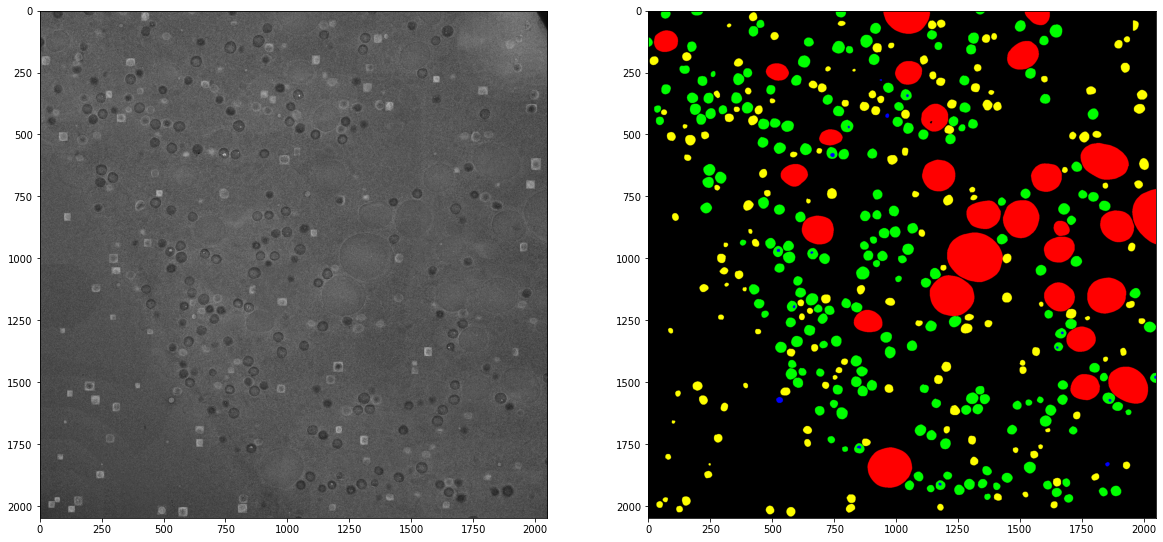

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(mask)

### Nanorods, create simple test image<a id='nanorods_simple'></a>

In [67]:
def box_mode_4to1(bbox_4):
    """
    bbox_n, n is boxmode in detectron2: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
    """
    bbox_4 = np.array(bbox['bbox'])
    bbox_0 = deepcopy(bbox_4).reshape(-1, 5)

    w = bbox_0[:, 2]
    h = bbox_0[:, 3]
    a = bbox_0[:, 4]
    c = np.abs(np.cos(a * math.pi / 180.0))
    s = np.abs(np.sin(a * math.pi / 180.0))
    # This basically computes the horizontal bounding rectangle of the rotated box
    new_w = c * w + s * h
    new_h = c * h + s * w

    # convert center to top-left corner
    bbox_0[:, 0] -= new_w / 2.0
    bbox_0[:, 1] -= new_h / 2.0
    # bottom-right corner
    bbox_0[:, 2] = bbox_0[:, 0] + new_w
    bbox_0[:, 3] = bbox_0[:, 1] + new_h
    # ignore angle
    bbox_0 = bbox_0[:, :4]

    bbox_1 = deepcopy(bbox_0)
    bbox_1[:, 2] -= bbox_1[:, 0]
    bbox_1[:, 3] -= bbox_1[:, 1]
    
    return bbox_1.flatten()

def box_corners_from_bbox4(bbox_4):
    """
    bbox_n, n is boxmode in detectron2: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
    Four corners labled counter clockwise
    """
    bbox_4 = np.array(bbox['bbox'])
    bbox_4_copy = deepcopy(bbox_4)

    w = bbox_4_copy[2]
    h = bbox_4_copy[3]
    a = bbox_4_copy[4]
    c = np.abs(np.cos(a * math.pi / 180.0))
    s = np.abs(np.sin(a * math.pi / 180.0))
    # This basically computes the horizontal bounding rectangle of the rotated box
    new_w = c * w + s * h
    new_h = c * h + s * w

    bbox_top_left_x = bbox_4_copy[0] - new_w / 2.0
    bbox_top_left_y = bbox_4_copy[1] - new_h / 2.0

    corners = np.zeros((4, 2))
    corners[0, :] = [bbox_top_left_x + w * s, bbox_top_left_y]
    corners[1, :] = [bbox_top_left_x, bbox_top_left_y + w * c]
    corners[2, :] = corners[1, :] + [h * c, h * s]
    corners[3, :] = corners[0, :] + [h * c, h * s]
    
    corners[:, 0] -= bbox_top_left_x
    corners[:, 1] -= bbox_top_left_y

    mask = np.zeros((int(new_w), int(new_h)))
    mask = cv2.fillPoly(mask,[corners.astype(int).reshape(-1, 1, 2)],255)
    return mask.T    
    
def get_img_patch(img, bbox_1):
    """
    bbox_1 is bounding box in detectron2 BoxMode1, or XYWH
    """
    bbox_1 = bbox_1.astype(int)
    patch = img[bbox_1[1]: bbox_1[1]+bbox_1[3], bbox_1[0]: bbox_1[0]+bbox_1[2]]
    return patch
    
    
    

#### Identify bounding box

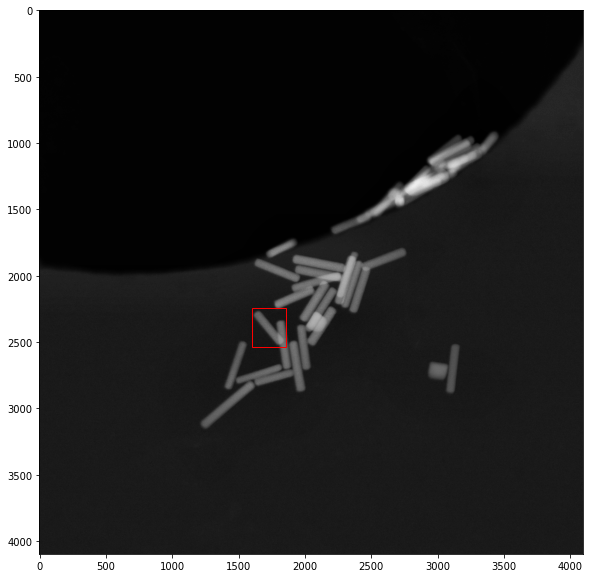

In [72]:
nanorods_img_dir = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train/'
nanorods_coco_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train_2classes_coco/train.json'

with open(nanorods_coco_file, 'r') as f:
    coco = json.load(f)
img = cv2.imread(nanorods_img_dir + coco['images'][0]['file_name'], 0)

bbox = coco['annotations'][0]
bbox_1 = box_mode_4to1(bbox['bbox']).flatten()


# plt.figure()
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(img, cmap='gray')
# Create a Rectangle patch
rect = patches.Rectangle((bbox_1[0], bbox_1[1]), bbox_1[2], bbox_1[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

#### Mask rbbox with bbox

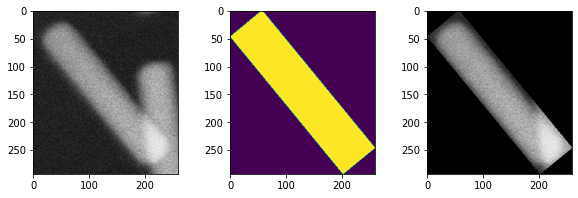

In [73]:
mask = box_corners_from_bbox4(bbox['bbox'])
patch = get_img_patch(img, bbox_1)
patch_masked = deepcopy(patch)
patch_masked[mask == 0] = 0

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(patch, cmap='gray')
ax[1].imshow(mask)
ax[2].imshow(patch_masked, cmap='gray')

#### Segment true nanorods